# Additive manufacturing surrogate
This experiments requires external data.  Make sure the folder ```/data/thermal_field_data``` contains the files ```data.npz``` and ```mesh.nas``` available in this anonymized [DropBox folder](https://www.dropbox.com/scl/fo/btn232lscruz9znrr1os6/AHoDbqnibIqJkoyVmih40X0?rlkey=9xm1a0t8iu4wyxbe5x6s970vw&st=mugczjr7&dl=0)

In [1]:
import sys; sys.path.append('../..')   # Allow relative imports from the parent folder

import numpy as np

from matplotlib import pyplot as plt 

import jax 
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
from jaxtyping import Array, Scalar

import optax

import equinox as eqx

from dynax import training
from dynax import evaluation
from dynax.function_models import LyapunovNN, OnsagerNetPotential, FICNN, \
                                  ConstantSkewSymmetricMatrix, \
                                  ConstantSPDMatrix, \
                                  ConstantMatrix, \
                                  MLP
from dynax.integration_models import ODESolver
from dynax.derivative_models import BaseModel, ISPHS
from dynax.losses import mse
from dynax.sphnn_tools import is_zero_gas_guarantee_valid

from pathlib import Path
import json

from functools import partial

import pyvista as pv

from util import colors
from util.model_meta import model_names, model_style

ACTIVATIONS = dict(
    softplus = jax.nn.softplus,
    tanh = jax.nn.tanh,
    relu = jax.nn.relu,
)

INITIALIZERS = dict(
    he_uniform = jax.nn.initializers.he_uniform(),
    glorot_uniform = jax.nn.initializers.glorot_uniform(),
    zeros = jax.nn.initializers.zeros,
)

### Matplotlib Settings 
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors.set_custom_cycle()

PLOT_DPI = 200

## Model and training definitions

In [2]:
def define_sPHNN_model(model_hyperparams: dict,
                       latent_state_size,
                       latent_input_size,
                       make_deriv_model: bool=False,
                       *, key):

    j_key, r_key, g_key, h_key = jr.split(key, 4)
    J = ConstantSkewSymmetricMatrix(latent_state_size, initialize=jnn.initializers.glorot_uniform(), key=j_key)
    # J = SkewSymmetricMatrix(latent_state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(latent_state_size, initializer=jnn.initializers.glorot_uniform(), key=r_key)
    # R = SPDMatrix(latent_state_size, activation=jnn.softplus, key=r_key)
    G = ConstantMatrix((latent_state_size, latent_input_size), initialize=jnn.initializers.glorot_uniform(), key=g_key)
    # G = MatrixFunction(latent_state_size, activation=jnn.softplus, key=g_key)


    ficnn = FICNN(latent_state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=jnn.softplus,
                  w_initializer=model_hyperparams['weight_initialization'],
                  b_initializer=model_hyperparams['bias_initialization'],
                  key=h_key)
    H = LyapunovNN(ficnn, minimum=jnp.zeros(latent_state_size))

    model = ISPHS(H, J, R, G)
    if make_deriv_model:
        return model
    else: 
        return ODESolver(model, max_steps=2**14)

def define_sPHNN_LM_model(model_hyperparams: dict,
                          latent_state_size,
                          latent_input_size,
                          make_deriv_model: bool=False,
                          *, key):
    j_key, r_key, g_key, h_key, minimum_key = jr.split(key, 5)

    J = ConstantSkewSymmetricMatrix(latent_state_size, initialize=jnn.initializers.glorot_uniform(), key=j_key)
    R = ConstantSPDMatrix(latent_state_size, initializer=jnn.initializers.glorot_uniform(), key=r_key)
    g = ConstantMatrix((latent_state_size, latent_input_size), initialize=jnn.initializers.glorot_uniform(), key=g_key)

    ficnn = FICNN(
        latent_state_size,
        "scalar",
        width=model_hyperparams["ficnn_width"],
        depth=model_hyperparams["ficnn_depth"],
        activation=jnn.softplus,
        w_initializer=model_hyperparams["weight_initialization"],
        b_initializer=model_hyperparams["bias_initialization"],
        key=h_key,
    )
    _H = LyapunovNN(ficnn)
    initial_minimum = jax.nn.initializers.normal(
        model_hyperparams["minimum_initializer_std"]
    )(minimum_key, _H.minimum.shape)
    H = eqx.tree_at(lambda x: x.minimum, _H, initial_minimum)
    assert H.minimum_learnable, "Minimum is not learnable for sPHNN_LM"
    sphnn_ = ISPHS(H, J, R, g)
    if make_deriv_model:
        return sphnn_
    else: 
        return ODESolver(sphnn_, max_steps=2**14)

def define_PHNN_model(model_hyperparams: dict,
                      latent_state_size,
                      latent_input_size,
                      make_deriv_model: bool=False,
                      *, key):

    j_key, r_key, g_key, h_key = jr.split(key, 4)
    J = ConstantSkewSymmetricMatrix(latent_state_size, initialize=jnn.initializers.glorot_uniform(), key=j_key)
    # J = SkewSymmetricMatrix(latent_state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(latent_state_size, initializer=jnn.initializers.glorot_uniform(), key=r_key)
    # R = SPDMatrix(latent_state_size, activation=jnn.softplus, key=r_key)
    G = ConstantMatrix((latent_state_size, latent_input_size), initialize=jnn.initializers.glorot_uniform(), key=g_key)
    # G = MatrixFunction(latent_state_size, activation=jnn.softplus, key=g_key)

    H = MLP(in_size=latent_state_size, out_size='scalar', 
            width_size=model_hyperparams['mlp_width'],
            depth=model_hyperparams['mlp_depth'],
            weight_initializer=model_hyperparams['weight_initialization'],
            bias_initializer=model_hyperparams['bias_initialization'],  
            activation=model_hyperparams['activation'], # Old hardcoded version: jnn.tanh,
            key=h_key)
    
    model = ISPHS(H, J, R, G)
    if make_deriv_model:
        return model
    else: 
        return ODESolver(model, max_steps=2**14)

def define_NODE_model(model_hyperparams: dict,
                      latent_state_size,
                      latent_input_size,
                      make_deriv_model: bool=False,
                      *, key):
    
    mlp = MLP(latent_state_size + latent_input_size, latent_state_size, 
              width_size=model_hyperparams['mlp_width'],
              depth=model_hyperparams['mlp_depth'],
              weight_initializer=model_hyperparams['weight_initialization'],
              bias_initializer=model_hyperparams['bias_initialization'],  
              activation=model_hyperparams['activation'], # Old hardcoded version: jnn.tanh,
              key=key)
    
    model = BaseModel(mlp, latent_state_size, latent_input_size)
    if make_deriv_model:
        return model
    else: 
        return ODESolver(model, max_steps=2**14)

def define_cPHNN_model(model_hyperparams: dict,
                      latent_state_size,
                      latent_input_size,
                      make_deriv_model: bool=False,
                      *, key):

    j_key, r_key, g_key, h_key = jr.split(key, 4)
    J = ConstantSkewSymmetricMatrix(latent_state_size, initialize=jnn.initializers.glorot_uniform(), key=j_key)
    # J = SkewSymmetricMatrix(latent_state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(latent_state_size, initializer=jnn.initializers.glorot_uniform(), key=r_key)
    # R = SPDMatrix(latent_state_size, activation=jnn.softplus, key=r_key)
    G = ConstantMatrix((latent_state_size, latent_input_size), initialize=jnn.initializers.glorot_uniform(), key=g_key)
    # G = MatrixFunction(latent_state_size, activation=jnn.softplus, key=g_key)

    H = OnsagerNetPotential(
        latent_state_size, 
        width_size=model_hyperparams['mlp_width'],
        depth=model_hyperparams['mlp_depth'],
        activation=model_hyperparams['activation'],
        weight_initializer=model_hyperparams['weight_initialization'],
        bias_initializer=model_hyperparams['bias_initialization'],  
        beta=model_hyperparams['beta'], 
        beta_learnable=model_hyperparams['beta_learnable'], 
        key=h_key
    )
    
    model = ISPHS(H, J, R, G)
    if make_deriv_model:
        return model
    else: 
        return ODESolver(model, max_steps=2**14)
    


def get_rmse(model, ts, ys, us=None):
    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
    return jnp.sqrt(jnp.mean(jnp.square(ys_pred - ys)))

def train_template(deriv_model, 
                   deriv_training_data: tuple, deriv_validation_data: tuple|None,
                   traj_training_data: tuple, traj_validation_data: tuple|None,
                   training_hyperparams: dict,
                   weights_dir=None, overwrite=False,
                   loss_fn = mse,
                   *, key):
    
    try:
        model = ODESolver(deriv_model)  # Max steps will be overridden by saved max_steps
        model = training.load_weights(weights_dir/Path('weights.eqx'), model)
        history = training.load_history(weights_dir/Path('history.npz'))
        # TEMPORARY: Model surgery to increase max_steps
        # model = eqx.tree_at(lambda m:m.max_steps, model, 2**20)
    except FileNotFoundError:
        deriv_model, deriv_history = training.fit_derivative(
            deriv_model, 
            *deriv_training_data,
            validation_data = deriv_validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['deriv_batch_size'],
            steps           = training_hyperparams['deriv_steps'],
            optimizer       = optax.adam(training_hyperparams['deriv_learning_rate']),
            log_loss_every  = 100,
            key             = key
            )
        
        model = ODESolver(deriv_model, max_steps=2**14)

        model, traj_history = training.fit_trajectory(
            model, *traj_training_data,
            validation_data = traj_validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['traj_batch_size'],
            steps           = training_hyperparams['traj_steps'],
            optimizer       = optax.adam(training_hyperparams['traj_learning_rate']),
            log_loss_every  = 100,
            key             = key
            )
        
        history = training.concatenate_histories(deriv_history, traj_history)

        training.save_weights(weights_dir/Path('weights'), model, overwrite)
        training.save_history(weights_dir/Path('history'), history, overwrite)

    return model, history

def evaluation_template(latent_model, 
                        end_to_end_model,
                        latent_training_data: tuple, latent_test_data: tuple,
                        end_to_end_training_data: tuple, end_to_end_test_data: tuple,
                        metrics_dir: Path):
    
    # Load RMSE data if available, otherwise compute it
    try:
        error_measures = np.load(metrics_dir/Path('error_measures.npz'))
        error_measures = dict(error_measures)
    except FileNotFoundError:
        error_measures = {
            'latent_test_rmse': get_rmse(latent_model, *latent_test_data),
            'latent_train_rmse': get_rmse(latent_model, *latent_training_data),
            'end_to_end_test_rmse': get_rmse(end_to_end_model, *end_to_end_test_data),
            'end_to_end_train_rmse': get_rmse(end_to_end_model, *end_to_end_training_data),
        }
        np.savez(metrics_dir/Path('error_measures.npz'), **error_measures)

    return error_measures


def get_hyperparams(file: Path, default_hyperparamse: dict):
    file = Path(file)
    try:
        with open(file, 'r') as f:
            hyperparams = json.load(f)
        return hyperparams

    except FileNotFoundError:
        file.parent.mkdir(parents=True, exist_ok=True)
        with open(file, 'w') as f:
            json.dump(default_hyperparamse, f, indent=4)
        return default_hyperparamse

def params_to_idxs(params, combinations):
    get_indx_of_closest = lambda x: jnp.argmin(jnp.linalg.norm(combinations - x, axis=-1))
    idxs = jax.vmap(get_indx_of_closest)(jnp.array(params))
    return idxs

def params_to_mask(params, combinations):
    idxs = params_to_idxs(params, combinations)

    mask = np.full((25,), False)
    mask[idxs] = True
    return mask


def make_batched(array: Array):
    """Adds a third dimension as first dimension if the array is 2D.
    If array is already 3D it is returned unchanged.
    For other dimensions an Value Error is thrown.

    Args:
        array (Array): Input Array

    Raises:
        ValueError: If the array is not 2D or 3D.

    Returns:
        array: 3D version of array.
    """
    if array.ndim == 2:
        return array[None, :, :]
    elif array.ndim == 3:
        return array
    else:
        raise ValueError('Array does not have 2 or 3 dimensions.')

def get_svd(snapshots: Array):
    """Calculates the (stacked) svd for snapshot matrices. Snapshots must be 3D.
    Useful for calculating the modes of multiple trajectories.
    U then is the trajectories of the latent variables,
    and modes = s[:, None] * V the modes.

    Args:
        snapshots (Array): Array of trajectories, shape=(n_batch, n_time, n_space).

    Returns:
        SVD matrices (tuple[Array]): U - Left singular matrix, shape=(n_batch, n_time, n_batch*n_time)
                                     s - singular values, shape=(n_batch*n_time)
                                     V - right singular matrix, shape=(n_batch*n_time, n_space)
    """
    n_traj, n_time, _ = snapshots.shape
    traj_stacked = np.concatenate(snapshots, axis=0)
    U, s, V = np.linalg.svd(traj_stacked, full_matrices=False)
    U = np.reshape(U, (n_traj, n_time, -1))

    return U, s, V

class SVDLatentSpace:

    shift: Scalar
    modes: Array
    trunk_modes: Array      # Trunkated modes
    singular_values: Array
    num_modes: int          # Number of trunkated modes to use for the projection

    def __init__(self, snapshots: Array, num_modes: int, normalize:bool=False, shift:Scalar=0.):
        """Create a SVD powered latent space projection mapping.

        Args:
            snapshots (Array): Array of trajectories, shape=(n_batch, n_time, n_space).
            num_modes (int): Number of modes to use for the SVD.
            normalize (bool, optional): If true rescales the latent space such that the data has unit variance. Defaults to False.
        """
        self.num_modes = num_modes
        self.shift = shift

        # make sure snapshots has a batch dimension
        snapshots = make_batched(snapshots - self.shift)
        U, s, Vt = get_svd(snapshots)
        
        # The following is what I used to do. However, by not multiplying the singular values into the modes and 
        # instead keeping them for the latent variables, I get a importance weighting of the latent variables 
        # for free, that might improve training substancially.
        # if normalize:
        #     scaling = np.std(U[:, :num_modes])
        #     s *= scaling
        # self.singular_values = s
        # self.modes = s[:, None] * Vt
        # self.trunk_modes = s[:num_modes, None] * Vt[:num_modes]
        self.singular_values = s
        if normalize:
            trunk_latent_variables = U[:,:,:num_modes] * s[None, None, :num_modes]
            scaling = np.std(trunk_latent_variables)

            self.modes = scaling * Vt
            self.trunk_modes = scaling * Vt[:num_modes]
        else:
            self.modes = Vt
            self.trunk_modes = Vt[:num_modes]

    def plot_singular_values(self, **kwargs):

        fig, ax = plt.subplots()

        ax.semilogy(self.singular_values)

        ax.set(
            xlabel='singular value index',
            ylabel='singular value',
            **kwargs
        )


    def set_num_modes(self, num_modes: int):
        self.num_modes = num_modes
        self.trunk_modes = self.modes[:num_modes]

    def compress(self, snapshots):

        snapshots = snapshots - self.shift

        if snapshots.ndim > 2:
            is_batched = True
            # Preprocess inputs
            snapshots = make_batched(snapshots)

            # Stack the batches along the time dimension
            n_traj, n_time, n_space = snapshots.shape
            snapshots = jnp.reshape(snapshots, (-1, n_space))
        else:
            is_batched = False

        # Solve least squares
        lstsq_sol = jnp.linalg.lstsq(self.trunk_modes.T, snapshots.T)
        latent_variables = lstsq_sol[0].T

        if is_batched:
            # Tansfrom back into batches
            latent_variables = jnp.reshape(latent_variables, (n_traj, n_time, -1))
        return latent_variables
    
    def decompress(self, latent_variables):
        return latent_variables @ self.trunk_modes + self.shift


class EndToEndModel(eqx.Module):

    latent_model: eqx.Module
    temp_svd: SVDLatentSpace
    source_svd: SVDLatentSpace

    def __init__(self, latent_model: eqx.Module, temp_svd: SVDLatentSpace, source_svd: SVDLatentSpace):
        self.latent_model = latent_model
        self.temp_svd = temp_svd
        self.source_svd = source_svd

    def __call__(self, ts: Array, y0: Array, us: Array):
        z0 = self.temp_svd.compress(y0)
        vs = self.source_svd.compress(us)
        zs_pred = self.latent_model(ts, z0, vs)
        return self.temp_svd.decompress(zs_pred)
        

## Load the data

In [3]:
data_dir = Path(R'..\..\data\additive_manufacturing_surrogate')
mesh = pv.read_meshio(data_dir/'mesh.nas')
data = np.load(data_dir/'data.npz')

fom_size = data['nodes'].shape[0]

## Set Hyperparameters
The following sets the hyperparameters for the experiment and/or the directory to save/load the trained models to.

In [4]:
# Directory of the files for saving or loading
save_dir = Path(R'results/run_0')

# Hyperparameters for a new experiment 
train_params=[
    ( 10. , 300. ),
    ( 20. , 500. )
]

train_mask = params_to_mask(train_params, data['combinations'])
training_parameters = data['combinations'][train_mask].tolist()

default_hyperparams = {
    'meta': dict(
        description = 'Performing training on 50 dimensional latent space with wider (64) neural nets.',
        num_instances = 15,
        latent_state_size = 50,
        latent_input_size = 50,
    ),
    'data': dict(
        training_parameters = training_parameters,
    ),
    'sPHNN': dict(
        ficnn_width             = 64,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
    ),
    'PHNN': dict(
        mlp_width               = 64,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'NODE': dict(
        mlp_width               = 64,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'cPHNN': dict(
        mlp_width               = 64,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus',
        beta                    = 0.1,
        beta_learnable          = False,
    ),
    'training': dict(
        deriv_batch_size      = 128,
        deriv_steps           = 20000,
        deriv_learning_rate   = 1e-3,
        traj_batch_size       = 32,
        traj_steps            = 10000,
        traj_learning_rate    = 1e-5,
    ),
}

# Load hyperparameters / Save hyperparameters if new experiment
hyperparams = get_hyperparams(save_dir/'hyperparameters.json', default_hyperparams)

# Substitute the activations and intialization schemes
for model in hyperparams.values():
    if 'activation' in model.keys():
        model['activation'] = ACTIVATIONS[model['activation']]
    if 'weight_initialization' in model.keys():
        model['weight_initialization'] = INITIALIZERS[model['weight_initialization']]
    if 'bias_initialization' in model.keys():
        model['bias_initialization'] = INITIALIZERS[model['bias_initialization']]


print('Training v, q =', hyperparams['data']['training_parameters'])

Training v, q = [[10.0, 300.0], [20.0, 500.0]]


## Prepare training data by applying SVD

In [5]:
training_indices = params_to_idxs(hyperparams['data']['training_parameters'], data['combinations'])
print('Training combinations:\n', data['combinations'][training_indices])

temp_svd   = SVDLatentSpace(data['temp'][training_indices], hyperparams['meta']['latent_state_size'], normalize=True, shift=293.15)
source_svd = SVDLatentSpace(data['source'][training_indices], hyperparams['meta']['latent_input_size'], normalize=True)

comp_data = dict(
    ts = data['ts'],
    temp = temp_svd.compress(data['temp']),
    source = source_svd.compress(data['source']),
)

train_data_traj = (comp_data['ts'], 
                   comp_data['temp'][training_indices],
                   comp_data['source'][training_indices],
                   )
fom_train_data_traj = (data['ts'], 
                       data['temp'][training_indices],
                       data['source'][training_indices],
                       )
y_train, y_t_train, u_train = training.make_derivative_data(*train_data_traj)
train_data_deriv = (y_train, y_t_train, None, u_train)

ts_vali, ys_vali, us_vali = (comp_data['ts'], 
                  np.delete(comp_data['temp'], training_indices, axis=0),
                  np.delete(comp_data['source'], training_indices, axis=0),
                  )
vali_data_traj = ((ts_vali, ys_vali[:,0], us_vali), ys_vali)
y_vali, y_t_vali, u_vali = training.make_derivative_data(ts_vali, ys_vali, us_vali)
vali_data_deriv = ((None, y_vali, u_vali), y_t_vali)

test_data = (ts_vali, ys_vali, us_vali)
fom_test_data = (data['ts'], 
                 np.delete(data['temp'], training_indices, axis=0),
                 np.delete(data['source'], training_indices, axis=0),
                 )

Training combinations:
 [[ 10. 300.]
 [ 20. 500.]]


## Train (or load) models


In [6]:
num_instances = hyperparams['meta']['num_instances']
results = {}

# Complete model definitions to include data specific information and collect the functions in a dict
model_definitions = {
    'sPHNN':    partial(define_sPHNN_model, 
                        make_deriv_model = True,
                        latent_state_size = hyperparams['meta']['latent_state_size'],
                        latent_input_size = hyperparams['meta']['latent_input_size'],
                        model_hyperparams = hyperparams['sPHNN']),
    'sPHNN-LM':    partial(define_sPHNN_LM_model, 
                        make_deriv_model = True,
                        latent_state_size = hyperparams['meta']['latent_state_size'],
                        latent_input_size = hyperparams['meta']['latent_input_size'],
                        model_hyperparams = hyperparams['sPHNN-LM']),
    'cPHNN':    partial(define_cPHNN_model,
                        make_deriv_model = True,
                        latent_state_size = hyperparams['meta']['latent_state_size'],
                        latent_input_size = hyperparams['meta']['latent_input_size'],
                        model_hyperparams = hyperparams['cPHNN']),
    'PHNN':     partial(define_PHNN_model,
                        make_deriv_model = True,
                        latent_state_size = hyperparams['meta']['latent_state_size'],
                        latent_input_size = hyperparams['meta']['latent_input_size'],
                        model_hyperparams = hyperparams['PHNN']),
    'NODE':     partial(define_NODE_model,
                        make_deriv_model = True,
                        latent_state_size = hyperparams['meta']['latent_state_size'],
                        latent_input_size = hyperparams['meta']['latent_input_size'],
                        model_hyperparams = hyperparams['NODE']),
}

# Complete training definition
train_model = partial(train_template,
                      deriv_training_data = train_data_deriv,
                      deriv_validation_data = vali_data_deriv,
                      traj_training_data = train_data_traj,
                      traj_validation_data = vali_data_traj,
                      training_hyperparams = hyperparams['training'],
                      loss_fn = mse)

evaluate_model = partial(evaluation_template,
                         latent_training_data = train_data_traj,
                         latent_test_data = test_data,
                         end_to_end_training_data = fom_train_data_traj,
                         end_to_end_test_data = fom_test_data,
                         )

# Load/Train the models

for model_name, definition in model_definitions.items():
    print(f'{model_name:-^40}')


    def train_instance(instance_id: int):
        key = jr.key(instance_id)
        model_key, loader_key = jr.split(key, 2)

        # Define the model
        _model = definition(key=model_key)

        # Train or load the model
        weights_dir=save_dir/f'{model_name}'/f'instance_{instance_id}'
        _model, history = train_model(_model,
                                      weights_dir=weights_dir,
                                      key=loader_key)
        model = training.resolve_constraints(_model)

        end_to_end_model = EndToEndModel(model, temp_svd, source_svd)

        # Evaluate the model
        error_measures = evaluate_model(model, 
                                        end_to_end_model,
                                        metrics_dir=weights_dir)

        instance_result = dict(
            model = model,
            history = history,
        ) | error_measures

        return instance_result

    # Sequential trianing
    results[model_name] = []
    for i in range(num_instances):
        results[model_name].append(train_instance(i))

-----------------sPHNN------------------
----------------sPHNN-LM----------------
-----------------cPHNN------------------
------------------PHNN------------------
------------------NODE------------------


#### Check if all sPHNNs are 0-GAS (Globally asymptotically stable)

In [8]:
for model_name in ['sPHNN', "sPHNN-LM"]:
    all_passed = True
    for n, instance_result in enumerate(results[model_name]):
        isphs = instance_result['model'].derivative_model
        if not is_zero_gas_guarantee_valid(isphs, 1e-8):
            all_passed = False
            print(f'{model_name}, instance {n} might not be 0-GAS.')
    if all_passed:
        print(f'All {model_name} instances are 0-GAS')


All sPHNN instances are 0-GAS
All sPHNN-LM instances are 0-GAS


## Evaluation
#### Box/Violinplot

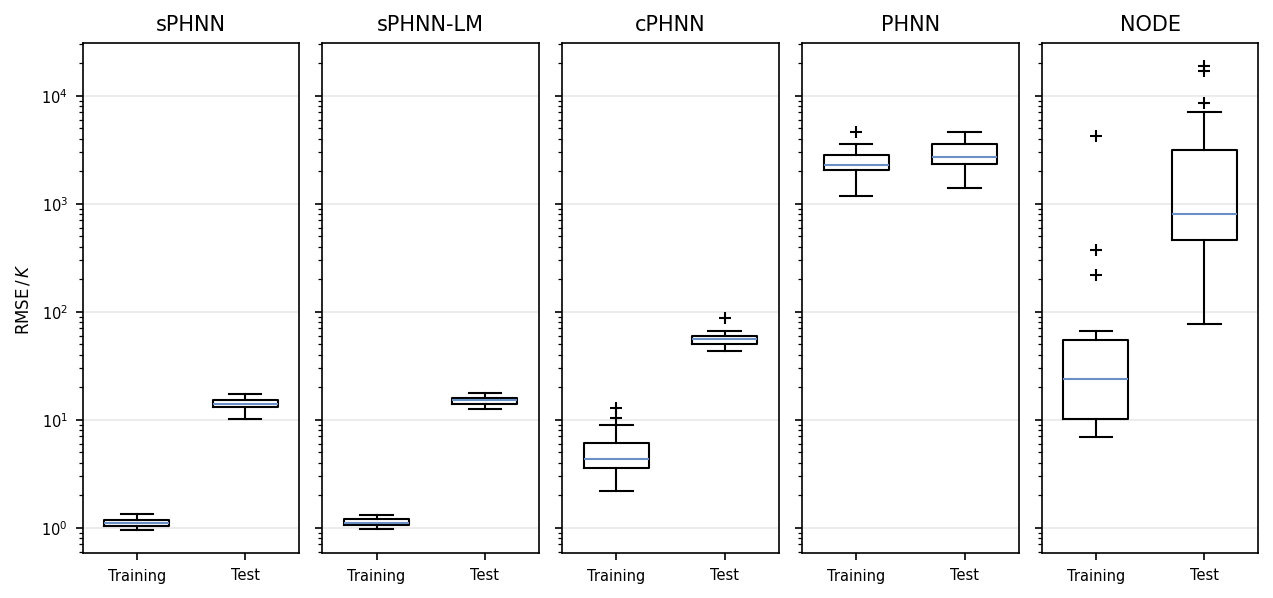

In [9]:
violinplot = False      # True -> Violinplot, False -> Boxplot
colorful = False        # If true, then the median lines are drawn in the model color

plot_rmse_data = {}
for model_type, instances in results.items():
    plot_rmse_data[model_type] = dict(
        # L_Training = [inst['latent_train_rmse'] for inst in instances],
        # L_Test = [inst['latent_test_rmse'] for inst in instances],
        Training = [inst['end_to_end_train_rmse'] for inst in instances],
        Test = [inst['end_to_end_test_rmse'] for inst in instances],
    )

n_results = len(plot_rmse_data)
fig, axes = plt.subplots(1, n_results, figsize=(1.7*n_results, 4), dpi=150, sharey=True)
if n_results == 1:
    axes = [axes]
# fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
for n, (ax, (model_type, rmses)) in enumerate(zip(axes, plot_rmse_data.items())):

    if violinplot:
        vp = ax.violinplot(rmses.values(),
                  showextrema=True, showmeans=False, showmedians=True)
        plt.setp(vp['cmedians'], color='red')
    else:
        bp = ax.boxplot(rmses.values(), notch=False, sym='+', vert=True, widths=(0.6,) * len(rmses))
        plt.setp(bp['medians'], color=model_style[model_type]['c'] if colorful else colors.theme_colors['lightblue'])

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

    ax.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=model_type,
        # xlabel='Data',
        ylabel=R'$\text{RMSE}\,/\,K$' if n==0 else '',
        xticks=np.arange(len(rmses))+1,
        xticklabels=rmses.keys(),
        # ylim=[0, 0.9],
        yscale='log',
        
    )

fig.tight_layout()
name_add_on = 'violinplot' if violinplot else 'boxplot'
plt.show()

#### Plot FOM snapshots

c:\Users\roth\Documents\Git Repositories\sPHNN\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


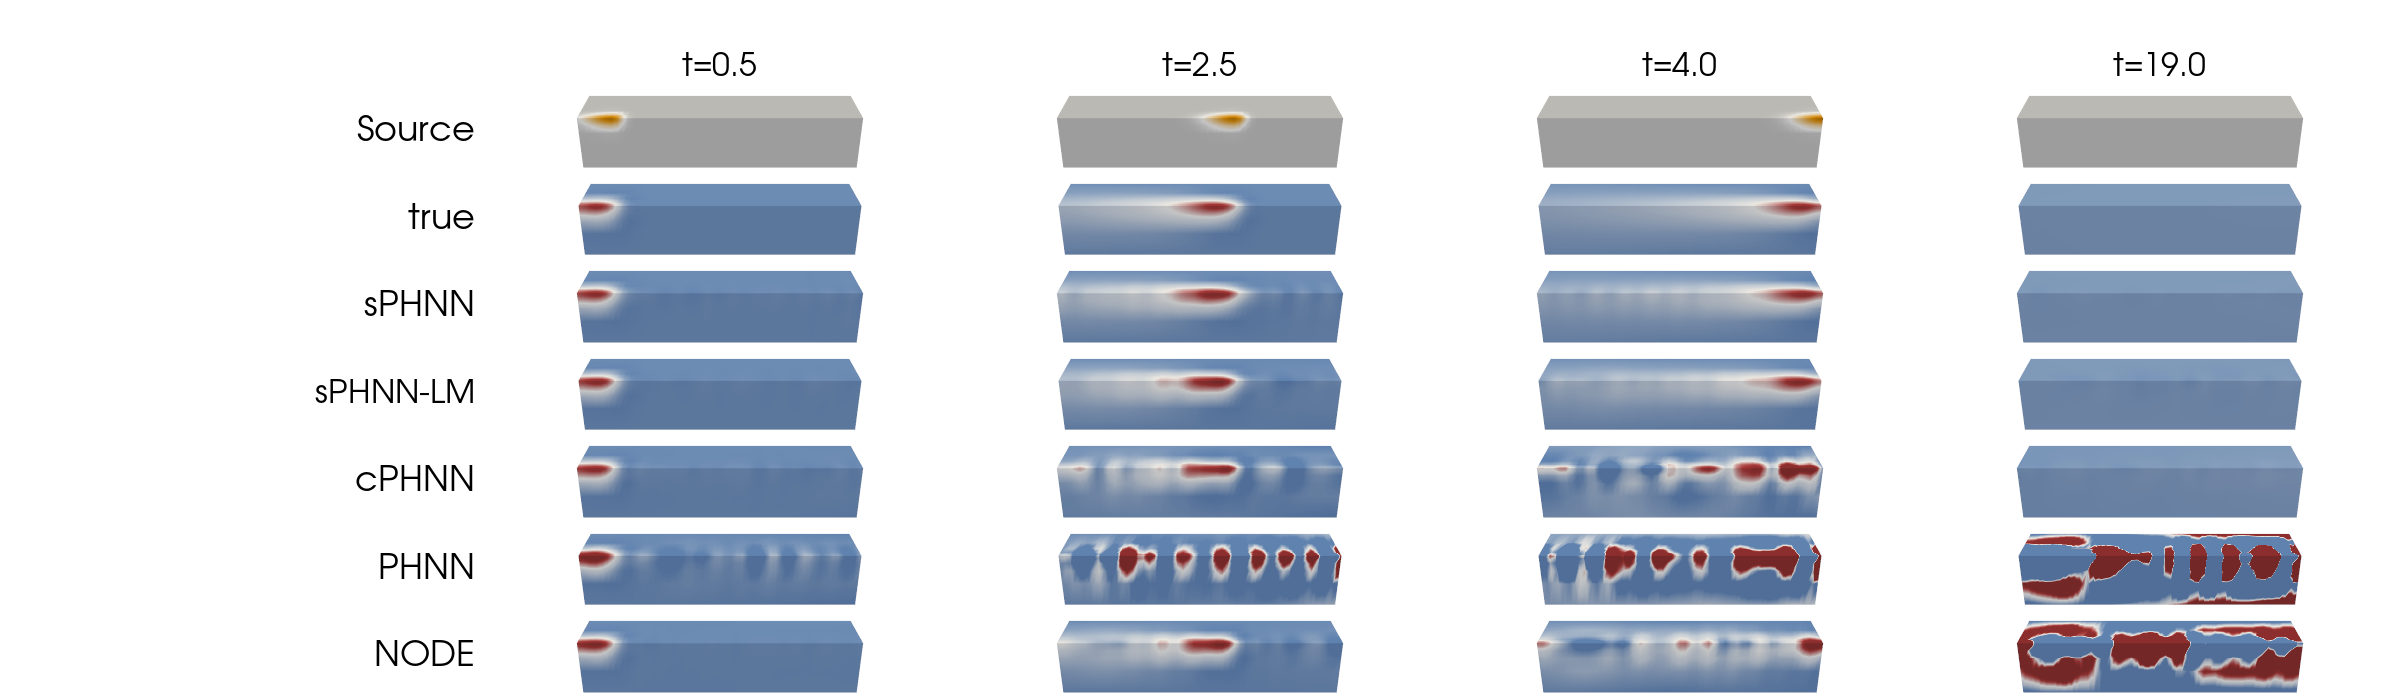

In [11]:
# Define custom colormaps
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgb
color_dict = {
    0.00: to_rgb(colors.scale_lightness(colors.theme_colors['lightblue'], 1.0)),
    0.30: to_rgb(colors.scale_lightness(colors.theme_colors['lightblue'], 1.5)),
    0.50: (1.0, 1.0, 1.0),
    0.85: to_rgb(colors.scale_lightness(colors.theme_colors['red'], 0.9)),
    1.00: to_rgb(colors.scale_lightness(colors.theme_colors['red'], 0.75)),
}

cdict = {}
for n, rgb in enumerate(['red', 'green', 'blue']):
    cdict[rgb] = [[k, v[n], v[n]] for k,v in color_dict.items()]

newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

color_dict = {
    0.00: to_rgb(colors.scale_lightness(colors.theme_colors['grey'], 1.0)),
    0.20: (1.0, 1.0, 1.0),
    0.85: to_rgb(colors.scale_lightness(colors.theme_colors['orange'], 0.9)),
    1.00: to_rgb(colors.scale_lightness(colors.theme_colors['orange'], 0.75)),
}

cdict = {}
for n, rgb in enumerate(['red', 'green', 'blue']):
    cdict[rgb] = [[k, v[n], v[n]] for k,v in color_dict.items()]

sourcecmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

# %% Plot
use_params = (12, 400)
use_batch = params_to_idxs([use_params], data['combinations']).squeeze()
velocity, power = data['combinations'][use_batch]
use_models = ['true', 'sPHNN', 'sPHNN-LM', 'cPHNN', 'PHNN', 'NODE']
sample_times = np.array([0.5, 2.5, 4, 19])

true_data = dict(
    ts = data['ts'],
    ys = data['temp'][use_batch],
    us = data['source'][use_batch],
)

ys = data['temp'][use_batch]
ts_comp = comp_data['ts']
ys_comp = comp_data['temp'][use_batch]
us_comp = comp_data['source'][use_batch]
sample_indices = np.argmin(np.abs(ts_comp[None, :] - sample_times[:, None]), axis=1)

clim = [ys.min(), ys.max()]

# p = pvqt.BackgroundPlotter(notebook=False, off_screen=False, shape=(len(use_models), sample_indices.size), border=False, window_size=(2400, 700))
p = pv.Plotter(notebook=True, off_screen=False, 
               shape=(len(use_models)+2, sample_indices.size+1), 
               border=False, window_size=(2400, 700))

p.subplot(1, 0)
p.add_text('Source', position='right_edge', font_size=15)
for col, time_idx in enumerate(sample_indices):
    p.subplot(1, col+1)
    mesh.point_data[f'temp_{time_idx}'] = true_data['us'][time_idx]
    p.add_mesh(mesh.copy(), scalars=f'temp_{time_idx}', 
                cmap=sourcecmap, show_scalar_bar=False,
                lighting=True,
                diffuse=0.5, specular=0.0, ambient=0.5,
                )

for col, time_idx in enumerate(sample_indices):
    p.subplot(0, col+1)
    p.add_text(f't={ts_comp[time_idx]}', position='lower_edge', font_size=15)
for row, model_name in enumerate(use_models):
    p.subplot(row+2, 0)
    p.add_text(model_name, position='right_edge', font_size=15)
for row, model_name in enumerate(use_models):
    if model_name == 'true':
        ys_pred_decomp = data['temp'][use_batch]
    else:
        # Choose best performing instance:
        test_rmses = [r['latent_test_rmse'] for r in results[model_name]]
        use_instance = np.argsort(test_rmses)[len(test_rmses)//2]   # 'Median' performing model
        # use_instance = np.argsort(test_rmses)[1]
        ys_pred_comp = results[model_name][use_instance]['model'](ts_comp, ys_comp[0], us_comp)
        ys_pred_decomp = temp_svd.decompress(ys_pred_comp)
    for col, time_idx in enumerate(sample_indices):
        p.subplot(row+2, col+1)
        mesh.point_data[f'temp_{time_idx}'] = ys_pred_decomp[time_idx]
        p.add_mesh(mesh.copy(), scalars=f'temp_{time_idx}', 
                   cmap=newcmp, clim=clim, show_scalar_bar=False,
                   lighting=True,
                   diffuse=0.5, specular=0.0, ambient=0.5,
                   )


p.link_views()
p.view_vector([0.,-1,0.5])
p.camera.zoom(3.2)
p.set_background('#FFFFFF')
p.show()

#### Plot RMSE over all trajectories

# of valid sPHNN predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid cPHNN predictions: 20
# of valid PHNN predictions: 20
# of valid NODE predictions: 20


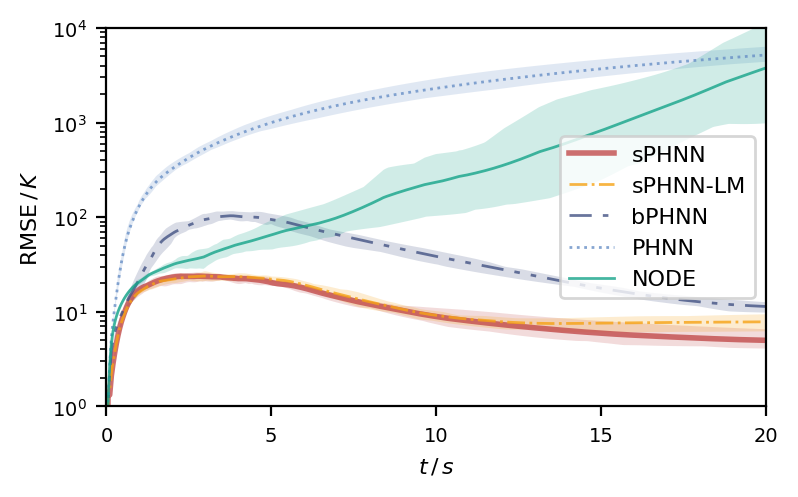

In [12]:
rmse_data = {}
for model_type, model_results in results.items():
    ys_preds = []
    for n, instance_result in enumerate(model_results):
        model = instance_result['model']
        try:
            ys_pred_comp = jax.vmap(model, in_axes=(None, 0, 0))(comp_data['ts'], comp_data['temp'][:,0], comp_data['source'])
            ys_preds.append(temp_svd.decompress(ys_pred_comp))
        except:
            print(f'{model_type}, instance {n} faild to integrate.')
    ys_preds = np.stack(ys_preds, axis=0)
    rmses = evaluation.rmse(ys_preds, data['temp'], axis=(1,3))    # RMSE over trajectories and space
    print(f'# of valid {model_type} predictions: {rmses.shape[0]}')

    rmse_data[model_type] = evaluation.get_statistics(rmses)
    
decomp_rmse = evaluation.rmse(temp_svd.decompress(comp_data['temp']), data['temp'], axis=(0,-1))

# Plot the RMSE
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=PLOT_DPI)
for model_type, model_data in rmse_data.items():
    ax.plot(data['ts'], model_data['interquartile_mean'], 
            **model_style[model_type], label=model_names[model_type])
    ax.fill_between(data['ts'], model_data['first_quartile'], model_data['third_quartile'], 
                    alpha=0.2, zorder=1, color=model_style[model_type]['c'], lw=0,
                    )
    
ax.set(
    xlabel='$t\,/\,s$',
    ylabel=R'$\text{RMSE}\,/\,K$',
    xscale='linear',
    xticks=[0, 5, 10, 15, 20],
    xlim=[0,20],
    yscale='log',
    ylim=[1,1e4],
)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()